In [1]:
import sys
from google.colab import drive

drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/finance_course/2021/lesson3')

Mounted at /content/drive


## Overnight Index Swap

Interest rate swaps (IRS) are usually used to mitigate the risks of fluctuations of varying interest rates, or to benefit from lower rates. We will always look at these products from the point of view of the **receiver of the floating leg**.

Overnight Index Swaps (OIS) are a particular kind of IRS which pay a floating coupon, determined by overnight rate fixings over the reference periods, against a fixed coupon.  By definition an OIS is defined by:

* a notional amount $N$;
* a starting date $d_0$;
* a sequence of payment dates $d_1,...,d_n$;
* a fixed rate $K$.

For simplicity in the following we are assuming that the fixed and floating legs of our OIS have the same notional and payment dates, although this is not necessarily always the case in practice.

### OIS Valuation
To evaluate the net present value (NPV) of such products the cash flows of each leg have to be calculated; today's NPV then is the sum of all the discounted cash flows.

#### Floating leg
At each payment date, the floating leg pays a cash flow determined as follows:

$$f_{\mathrm{float},~i} = N \Bigg\{\prod_{d=d_{i-1}}^{d=d_i-1}\Big(1+r_{\mathrm{O/N}}(d)\cdot\frac{1}{360}\Big) -1 \Bigg\}$$

Strictly speaking this formula is valid for an EONIA swaps (i.e.~for OIS swaps in EUR) other currencies might have different conventions. The $\frac{1}{360}$ fraction appears because EONIA rates are quoted using the ACT/360 day-count convention. In addition we are making the simplifying assumption of ignoring weekends and holidays, so we assume that each overnight rate is valid for only one day.
The sum of the discounted expected values of these cash flows is

$$\mathrm{NPV}_{\mathrm{float}} = \sum_{i=1}^{n}D(d_i)\mathbb{E}[f_{\mathrm{float},~i}]$$
where $D(d)$ is the discount factor with expiry $d$. On the other hand, by definition (remember last lesson on forward rates), we also have the following relationship

$$\mathbb{E}[f_{\mathrm{float},~i}] = N\cdot\Big(\frac{D_{\mathrm{OIS}}(d_{i-1})}{D_{\mathrm{OIS}}(d_{i})} - 1\Big)$$
hence
$$\mathrm{NPV}_{\mathrm{float}} = N\cdot \sum_{i=1}^{n}D(d_i) \Big(\frac{D_{\mathrm{OIS}}(d_{i-1})}{D_{\mathrm{OIS}}(d_{i})} - 1\Big)$$
where $D_{\mathrm{OIS}}(d)$ is the discount factor implied by OIS prices (we will see how to derive it).

Since the correct curve to discount OIS is the overnight index itself we have that $D = D_{\mathrm{OIS}}$ so the NPV simplifies to

$$\begin{equation}
  \begin{split}
    \mathrm{NPV}_{\mathrm{float}} & = N\cdot\sum_{i=1}^{n}[D(d_{i-1}) - D(d_i)] =  \\
    &= N\cdot[(D(d_{0}) - D(d_{1})) + (D(d_{1}) - D(d_{2})) + ... + (D(d_{n-1}) - D(d_{n}))]\\
    &= N \cdot [D(d_0) - D(d_n)]
  \end{split}
\end{equation}
$$

#### Fixed leg
The calculation for the fixed leg is simpler; each cash flow is  equal to

$$f_{\mathrm{fixed},~i}=N\cdot K\cdot \frac{d_i - d_{i-1}}{360}$$
so the NPV of the fixed leg is

$$\mathrm{NPV}_{\mathrm{fixed}} = N\cdot K\cdot \sum_{i=1}^{n}D_{\mathrm{OIS}}(d_{i})\frac{d_i - d_{i-1}}{360}$$

### Discount Factor Determination from Market Quotes

Our ultimate goal is to take a series of Overnight Index Swap quotations, and determine the discount factors implied by their prices. To do this we will build a class to represent OIS and compute its value given particular discount curve. Then we will use this class, with a numerical optimizer, to *invert* the relation which ties the NPV to the discount curve so that the implied discount factors can be determined from OIS prices (market quotes).

In [2]:
# define OIS class
class OvernightIndexSwap:
    def __init__(self, notional, payment_dates, fixed_rate):
        self.notional = notional
        self.payment_dates = payment_dates
        self.fixed_rate = fixed_rate
        
    def npv(self, dc):
        return self.npv_floating_leg(dc) - self.npv_fixed_leg(dc)
    
    def npv_floating_leg(self, dc):
        return self.notional * (dc.df(self.payment_dates[0]) -
                                dc.df(self.payment_dates[-1]))

    def npv_fixed_leg(self, dc):
        v = 0
        for i in range(1, len(self.payment_dates)):
            tau = (self.payment_dates[i] - self.payment_dates[i-1]).days / 360
            v += dc.df(self.payment_dates[i]) * tau
        return self.notional*self.fixed_rate*v
                    

To test the newly developed class we need a discount curve. 
In the following example a fake curve will be defined, and then used to build an OIS contract.

In [3]:
from datetime import date
from finmarkets import DiscountCurve

ois = OvernightIndexSwap(
            # the notional, one million
            1e6,
            # the list of payment dates
            [date(2020, 10, 21), date(2021, 1, 21),
             date(2021, 4, 21), date(2021, 7, 21),
             date(2021, 10, 21)],
            # the fixed rate, 2.5%
            0.025)

# fake discount curve
curve = DiscountCurve([date(2020, 10, 21), date(2021, 6, 1),
                       date(2022, 1, 1)],
                      [1.0, 0.98, 0.82])

print ("OIS NPV: {:.2f}".format(ois.npv(curve)))

OIS NPV: 105332.19


## Bootstrapping Technique 

As we said before we would like to determine a *real* discount curve starting from the market quotes of a set of Overnight Index Swaps with different maturities, this will be done via a technique called bootstrapping.
This is the ABC of financial mathematics, since you almost always need a
discount curve to price every contract. We are going to concentrate on EONIA swaps in order to build an EUR discount curve.
The underlying assumption is that market quotes represent the **fair** prices of the OIS so they make the swap NPVs null (the fair price is an estimate of what a willing buyer would pay a willing seller for a given asset, assuming both have a reasonable knowledge of the asset's worthness).

### Building OIS Instances
The first step involves getting data, the swap market quotes. This is not quite easy since EONIA swap market is over the counter (OTC) and it’s not straightforward to access it. Anyway in the file [ois_data.xlsx](https://github.com/matteosan1/finance_course/raw/develop/libro/input_files/ois_data.xlsx) it is available 
a data-set of of swap quotes (which actually are rates rather prices) suitable for our needs.
With the help of the $\tt{pandas}$ module the data-set can be inspected:

In [4]:
# read from ois_data.xlsx
import pandas as pd
mq = pd.read_excel('https://github.com/matteosan1/finance_course/raw/develop/libro/input_files/ois_data.xlsx')
mq.head()

,months,quote
0,1,-0.350
1,2,-0.347
2,3,-0.348
3,4,-0.350
4,5,-0.350


Let’s say we want to build a 15 months swap instance using data contained in $\tt{ois\_data}$ file. Be careful when doing this operation and double check the units of rates, quotes, etc...in this case
for example quotes are expressed in percent so you need to multiply by 0.01 before using them.
Another detail to check is that 15 months quote is not the fifteenth entry in the $\tt{DataFrame}$ (actually it is the twelfth).

In [5]:
from finmarkets import generate_dates

# create an OvernightIndexSwap with a market quote
start_date = date.today()
ois = OvernightIndexSwap(1e6, 
                        generate_dates(date.today(), 15),
                        mq['quote'].tolist()[12]*0.01)
ois.payment_dates[-1]

datetime.date(2023, 1, 1)

### Bootstrap Algorithm

Keep aside for a moment our swaps and introduce the *bootstrap algorithm*. In finance, bootstrap is a method for constructing a (zero-coupon) fixed-income yield curve from the prices of a set of coupon-bearing products, e.g. bonds and swaps. The term structure of spot returns is obtained from the bond yields by solving for them recursively, by *forward substitution*: this iterative process is what is called the bootstrap method. 
The usefulness of bootstrap is that using only a few carefully selected zero-coupon products, it becomes possible to derive swap forward and spot rates for all maturities given the solved curve.

To illustrate the algorithm let’s consider the following example which can be solved, at least parrtially, analytically.
We have some coupon paying bonds (coupon of 4\%, 5\%, 6\%, 7\% and 8\% respectively) with
maturities ranging from 1 to 5 years, each having a value of €100 and traded at par (traded at its face value). To determine the zero-coupon yield curve proceed as follows:

* at the end of first year the discounted cash flow of the first bond is €104 (face value plus the coupon) times the discount factor, so the implied *fair* rate 

$$100 = \cfrac{104}{(1 + S_{1y})}\implies S_{1y} =  104/100 - 1 = 4\%$$

* at the end of second year the sum of the cash flows of the 2nd bond can be compared to its trading price to compute the 2-year spot rate $S_{2y}$ (using the previously derived value of $S_{1y}$)

$$100 = \cfrac{5}{(1 + S_{1y})} + \cfrac{105}{(1 + S_{2y})^{2}}$$

$$\begin{equation*}
\begin{split}
& 100 = 5 / (1 + 0.04) + 105 / (1 + S_{2y})^{2}\qquad\Rightarrow\qquad S_{2y}^2  + 2 S_{2y}  - 0.103030 = 0 \\
& S_{2y} = - 1 \pm \sqrt{1 + 0.103030} = \begin{cases}-2.05023 \\ 0.0503\end{cases}
\end{split}
\end{equation*}$$

From the third year on, still keeping the same reasoning, we obtain equation of third order or more which are not easily analitically solvable. For example following the equation for the fifth bond after five years:

$$100 = \cfrac{8} {(1 + S_{1y})} + \cfrac{8} {(1 + S_{2y})^{2}}+ \cfrac{8} {(1 + S_{3y})^{3}} + \cfrac{8} {(1 + S_{4y})^{4}} + \cfrac{108} {(1 + S_{5y})^{5}}$$

Assuming we have already determined the previous rates:

| years | coupon rate | bond price | rate|
|:----:|:----:|:----:|:----:|
|1 | 1.00 % | 100 | 4.00% |
|2 | 2.00 % | 100 | 5.03% |
|3 | 3.00 % | 100 | 6.08% |
|4 | 4.00 % | 100 | 7.19% |
|5 | 5.00 % | 100 | ??? |

we can solve also the last one numerically. This can be done by using $\tt{brentq}$ function as for the yield to maturity.

![](https://drive.google.com/uc?id=1AmCejDf3ifMz9Zc6XOHeAk-5Tc23Zbrw)

In [6]:
# find zeros of previous eq. with brentq
from scipy.optimize import brentq

def func(x):
    return 100 - 8/(1+0.04) - 8/(1+0.0503)**2 - 8/(1+0.0609)**3 - \
           8/(1+0.0719)**4 - 108/(1+x)**5

r = brentq(func, 0, 0.5)
print (r)

0.08358311708621957


The very same mechanism can be generalized and extended to more maturities to get a more detailed yield curve. In general terms the previous system can be written as:

$$\begin{equation*}
\begin{cases}
f_1(S_1, p_1) = 0 \\
f_2(S_1, S_2, p_2) = 0 \\
f_3(S_1, S_2, S_3, p_3) = 0 \\
f_4(S_1, S_2, S_3, S_4, p_4) = 0 \\
\cdots
\end{cases}
\end{equation*}
$$
where $S_i$ are the unknown spot rates and $p_i$ the market quotes of the considered products. 

The iterative procedure we have applied before exploits the first equation to find $S_1 = f_1^{-1}(p_1)$, the second to find $S_2 = f_2^{-1}(S_1, p_2)$ and so on and so forth.

This algorithm works since each equation will determine exactly one free spot rate which is not already determined by the others.

### Bootstrap as Minimization Problem
Instead of iteratively finding the solution of each equation as before, we could define a vector of spot rates $\mathbf{S} = (S_1, S_2, S_3,\ldots)$ seeking for a particular $\mathbf{\hat{S}}$ which solves the following equation:

$$F = f_1^2(\hat{S}_1,p_1) + f_2^2(\hat{S}_1, \hat{S}_2,p_2) + f_3^2(\hat{S}_1, \hat{S}_2, \hat{S}_3,p_3) + f_4^2(\hat{S}_1, \hat{S}_2, \hat{S}_3, \hat{S}_4,p_4) + \ldots = 0$$

Under this terms the bootstrap technique can be considered as a minimization problem, indeed we need to find $\mathbf{\hat{S}}$ which makes $F$ zero, or at least *minimize* it making $F$ as close as possible to 0.

Notice that each $f_i$ is squared since we want all of them to be minimized at the same time and not only $F$ globally (without the squared there may be cancellation effects between the terms of the sum).


### Minimization Algorithm

A minimization algorithm follows these steps:

* define an *objective function* i.e. the function that is actually minimized to reach our goal;
* set the initial value of the unknown parameters and their range of variability;
* the minimizer will compute the objective function value;
* then it will move the parameter values in such a way to find a smaller value of the objective function (e.g. following the derivative w.r.t. each parameter);
* if there are contraints the step above will take them into account;
* the last two steps will be repeated until further variations of the $\mathbf{x}$ values won’t change significantly the objective function (i.e. we have found a minimum of the function so the minimisation process is completed !).

Let's see two examples of $\tt{python}$ applications of the minimization function $\tt{scipy.optimize.minimize}$

### Example 
Find the dimensions that will minimize the costs to manufacture a circular cylindrical can of volume, $330~\mathrm{cm}^3$.

Clearly to minimize the costs the company needs to reduce the can surface, given the required volume.

![](https://drive.google.com/uc?id=1LQaX8j10nq1KgRu4RdR4Ade96fsMNxa6)

$$ S(r, h) = 2\pi rh + 2\cdot(\pi r^2) $$

On the other hand we want the volume to be $330~\mathrm{cm}^3$ so we can remove $h$ from the previous equation:

$$ V = \pi r^2 h = 330\quad\implies h = \cfrac{330}{\pi r^2} $$

So in the end the surface function to be minimized is:

$$ S(r) = 2\pi rh + 2\cdot(\pi r^2) = \cfrac{2\cdot 330}{r} + 2\cdot(\pi r^2)$$

So we implement the objective function $\tt{x[0]}$ is the can radius:

In [7]:
from math import pi

def of(x):
    return 660/x[0] + 2 * pi * x[0]**2

Set the limits to our unknown variable and its initial value:

In [8]:
x0 = [1]
bounds = [(0.1, 100)]

Finally we run the minimization:

In [9]:
from scipy.optimize import minimize

r = minimize(of, x0, bounds=bounds)
print (r)

      fun: 264.3568109148405
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([5.68434189e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 24
      nit: 9
   status: 0
  success: True
        x: array([3.7449385])


So to minimize the cost the company should produce cans with a radius of about 3.745 cm.

### Example with Constraint
We are going to fence in a rectangular field. If we look at the field from above the cost of the vertical sides are €10/m, the cost of the bottom is €2/m and the cost of the top is €7/m. If we have €700 determine the dimensions of the field that will maximize the enclosed area.

![](https://drive.google.com/uc?id=1JhL79-u0uDs8nkcEtletOWypdKWWZDBc)

In this example there are two differences w.r.t before:

* we want to maximize a quantity (not minimize);
* there is a contraint (we have a limited amount of money).

So let's repeat the steps as before. The objective is to maximize the enclosed area $A$ so we can *minimize* the quantity $-A$. If we define the length and the width of the field with $\tt{x[0]}$ and $\tt{x[1]}$ (items of the list $\tt{x}$ we get:

In [10]:
def of(x):
    return -x[0]*x[1]

Now we can set the boundaries for length and width and their initial values (1 m each):

In [11]:
x0 = [1, 1]
bounds = [(1, 100) for _ in range(len(x0))]

We have also to impose the constraint on the money. This is done by defining a function that compute the money spent with the fence and compare it to €700. 
The constraint is passed to the minimizer with a dictionary which has two keys: $\tt{type}$ with value $\tt{eq}$ (like equality) since we want to spend all of our available money so the fence has to cost €700

$$\mathrm{fence~cost} = l\cdot10 + l\cdot10 + w\cdot2 + w\cdot7 = 700$$
$$l\cdot10 + l\cdot10 + w\cdot2 + w\cdot7 - 700 = 0$$

, $\tt{fun}$ whose value is the constraint function. 

In [12]:
def const(x):
    return 2*x[0]*10 + x[1]*7 + x[1]*2 - 700

constraints = {'type':'eq', 'fun':const}

Finally we can call the minimizer.

In [13]:
r = minimize(of, x0, bounds=bounds, constraints=constraints)
print (r)

     fun: -680.555555555548
     jac: array([-38.88889313, -17.5       ])
 message: 'Optimization terminated successfully.'
    nfev: 16
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([17.49999818, 38.88889293])


So the field will come out $17.5$ m long and $38.9$ m wide.

## Local Minima

In [14]:
import numpy as np
from math import pi

def func(x):
    return np.cos(3*pi*x)/x

![](https://drive.google.com/uc?id=1NarHa2FYJxDT6nq_sm6H57PUJcwHBxxx)

In [15]:
from scipy.optimize import minimize
x0 = [1.1]
bounds = [(0.01, 2)]

r = minimize(func, x0, bounds=bounds)
print (r)

      fun: array([-1.00569871])
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.4408921e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 16
      nit: 5
   status: 0
  success: True
        x: array([0.98865633])


In [16]:
from scipy.optimize import minimize
x0 = [0.5]
bounds = [(0.01, 2)]

r = minimize(func, x0, bounds=bounds)
print (r)

      fun: array([-3.17151711])
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([9.32587341e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 16
      nit: 5
   status: 0
  success: True
        x: array([0.29691798])


### OIS Example
Back to our Overnight Index Swap, the general idea here is to find the discount curve $\mathcal{C}$ such that it prices as much correctly as possible each OIS by minimizing the sum of the squared NPVs (our $f_i$):

$$\mathrm{min}_{\mathcal{C}} \Big\{\sum_{i=1}^{n}\mathrm{NPV}^2(\mathrm{OIS}_i, \mathcal{C})\Big\}$$

A discount curve is characterized by pillar dates and the corresponding discount factors. The description of the problem we have given above does not, in theory, specifies any constraint on the number of pillar dates of the discount curve $\mathcal{C}$ we are going to find.
However, the pillar dates determine the number of unknown variables (i.e.~the dimensionality $N$ of the optimization problem). A curve with $N$ pillar dates has also $N$ discount factors (note that the first discount factor with value date equal to the today date, is constrained to 1). **In practice, therefore, it makes sense to choose the pillar dates in such a way that there are exactly the right number of degrees of freedom in the optimization to match data, so equal number of pillars and market quotes.** Hence the natural choice is to choose the pillar dates of the discount curve equal to the set of expiry dates of the swaps.

Once we've fixed $\mathbf{d}$ to be a vector of pillar dates equal to the expiry dates of the OIS swaps, and we use the notation $\mathbf{x}$ to represent the vector of unknown pillar discount factors, then the problem becomes:

$$ F= \mathrm{min}_{\mathbf{x}} \Big\{\sum_{i=1}^{N}\mathrm{NPV}^2(\mathrm{OIS}_i, \mathcal{C}(\mathbf{d}, \mathbf{x}))\Big\}\qquad (f_i^2 = \mathrm{NPV}^2(\mathrm{OIS}_i, \mathcal{C}(\mathbf{d}, \mathbf{x})))$$
which is our optimization problem (**to find the minimum of the above expression as a function of x**) that can be solved as before using the available numerical optimization routines in $\tt{python}$.

So first let's create the swaps according to all the available market quotes and also the pillar dates of our final discount curve:

In [17]:
# creates the OIS from market quotes
from finmarkets import generate_dates

observation_date = date.today()
pillar_dates = [observation_date]
swaps = [] # container of the OIS objects 
for i in range(len(mq)):
    swap = OvernightIndexSwap(1e6,
                              generate_dates(observation_date,
                                             mq['months'].tolist()[i]),
                              0.01*mq['quote'].tolist()[i])
    pillar_dates.append(swap.payment_dates[-1])
    swaps.append(swap)

So implement the method to the swaps we have just created.

* define the objective function: the sum of the squared NPVs of the OIS 

In [18]:
# define objective function
import numpy as np
from finmarkets import DiscountCurve

def objective_function(x):
    curve = DiscountCurve(pillar_dates, x)
    s = 0
    for swap in swaps:
        s += swap.npv(curve)**2
    return s

* set the initial value of the discount factors ($x_i$) to 1 with a range of variability $[ 0.01, 10]$, in addition the first element of the list, today’s discount factor, will be fixed to 1 (variability $[1, 1]$)

In [19]:
# set boundaries and guess values
x0 = [1 for _ in range(len(pillar_dates))]
bounds = [(0.01, 10) for _ in range(len(pillar_dates))]
bounds[0] = (1, 1)

* finally we can launch the minimizer to find the discount factors ($\mathbf{x}$)

In [20]:
# minimize
r = minimize(objective_function, x0, bounds=bounds)
print (r)

      fun: 0.0007426408965325974
 hess_inv: <34x34 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.42448911e+05,  8.34694785e-01,  8.93835186e-01,  1.00379925e+00,
        1.16913946e+00,  1.36259798e+00,  1.63549687e+00,  1.95235107e+00,
        2.33885953e+00,  2.77210476e+00,  3.28109877e+00,  3.83437829e+00,
       -8.96816706e+00, -6.42059236e+00, -7.00056275e+00, -7.37823581e+00,
        7.90539227e-01,  4.93726443e+00,  8.93735291e+00,  1.13290166e+01,
        1.06070980e+01,  6.46100004e+00,  3.76086959e-01, -5.22006771e+00,
       -8.21401182e+00, -7.12644185e+00, -1.50554746e+01, -1.14759278e+01,
       -3.30225054e+00,  2.84496852e+01, -6.66397434e+00, -3.88158073e+00,
       -8.61157731e+00,  6.75822876e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1015
      nit: 12
   status: 0
  success: True
        x: array([1.        , 1.00030147, 1.00058831, 1.00089012, 1.00119726,
       1.00147021, 1.00177765, 1.00207128, 1.00237487, 1.

Some diagnostic number/plot.

In [21]:
# print initial and final objective function values
print (objective_function(x0))
print (objective_function(r.x))

1055849118336.7455
0.0007426408965325974


![](https://drive.google.com/uc?id=17VFztegQzIOh1IMKf49BJlVXO51F_n5P)
![](https://drive.google.com/uc?id=1poBs7n51TC_rrXww1mzbqBkdHH5ZoyoD)

Finally we can create the discount curve implied by the market quote of our swaps. 

$$ \mathrm{df} = e^{-rt} \quad\implies \mathrm{log(df)} = -rt\quad\implies r = -\mathrm{log(df)}/t$$

In [22]:
# create the discount curve with our factors
from math import log
from dateutil.relativedelta import relativedelta
from finmarkets import DiscountCurve

curve = DiscountCurve(pillar_dates, r.x)
# find 40y implied rate
d = pillar_dates[0] + relativedelta(years=40)

rate = -log(curve.df(d))/40
print (rate)

0.011020626773921054


In [24]:
print (curve.df(d))

0.6435052644880289


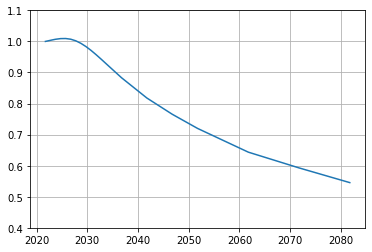

In [23]:
from matplotlib import pyplot as plt

plt.plot(pillar_dates, r.x)
plt.grid(True)
plt.ylim(0.4, 1.1)
plt.show()